In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import pandas as pd

import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

import pathlib
import matplotlib.pyplot as plt

import pandas as pd

In [3]:
image_shape = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4', input_shape = image_shape+(3,))
])

labels = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels = np.array(labels['background'])
labels[:5]

array(['tench', 'goldfish', 'great white shark', 'tiger shark',
       'hammerhead'], dtype=object)

In [11]:
bird_classifier = hub.KerasLayer('https://tfhub.dev/google/aiy/vision/classifier/birds_V1/1', input_shape = image_shape+(3,))

labels = pd.read_csv('aiy_birds_V1_labelmap.csv')
labels.head()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


,id,name
0,964,background
1,0,Haemorhous cassinii
2,1,Aramus guarauna
3,2,Rupornis magnirostris
4,3,Cyanocitta cristata


In [63]:
def get_mobilenet_pred(image_path, classifier = classifier):
    img = Image.open(image_path)
    img = np.array(img)/255.0
    result = classifier.predict(img[np.newaxis, ...])
    predicted_label_indices = np.argpartition(result[0], -4)[-4:]
    return labels[predicted_label_indices]

In [67]:
get_mobilenet_pred('per_imgs/dataset_3/cropped/test/neg/5_20-00068-c.png')

array(['crib', 'gasmask', 'apron', 'brassiere'], dtype=object)

---

load input data

---

In [24]:
train_dir = pathlib.Path('per_imgs/dataset_3/cropped/train')
val_dir = pathlib.Path('per_imgs/dataset_3/cropped/val')
test_dir = pathlib.Path('per_imgs/dataset_3/cropped/test2')

In [25]:
train_images_dict = {
    'pos': list(train_dir.glob('pos/*')),
    'neg': list(train_dir.glob('neg/*')),
}

val_images_dict = {
    'pos': list(val_dir.glob('pos/*')),
    'neg': list(val_dir.glob('neg/*')),
}

test_images_dict = {
    'pos': list(test_dir.glob('pos/*')),
    'neg': list(test_dir.glob('neg/*')),
}

labels_dict = {
    'pos': [0, 1],
    'neg': [1, 0]
}

In [4]:
def assign_x_y(images_dict):
    
    X, y = [], []

    for label, images in images_dict.items():
        for image in images:
            img = cv2.imread(str(image))
            resized_img = cv2.resize(img, (224, 224))

            prep_img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
            
            X.append(prep_img)
            y.append(labels_dict[label])
            
            # convert to np array and scale
            
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [5]:
X_train, y_train = assign_x_y(train_images_dict)
X_val, y_val = assign_x_y(val_images_dict)
X_test, y_test = assign_x_y(test_images_dict)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


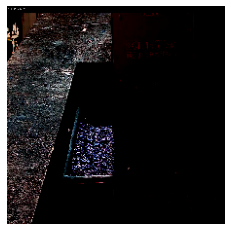

In [8]:
plt.axis('off')
plt.imshow(X_train[5])

---

building the model

---

1_3 had added dense layer with no preprocessing except for /255.

In [18]:
t_model_1_6 = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', input_shape = (224, 224, 3), trainable = False),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),    
    layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(units = 2, activation = 'softmax')
])

In [19]:
t_model_1_6.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta = 0.01, patience=4)

In [21]:
t_model_1_6.fit(X_train, y_train, epochs = 20)

Epoch 1/20
52/52 [==============================] - 52s 943ms/step - loss: 0.3545 - accuracy: 0.8473
Epoch 2/20
52/52 [==============================] - 57s 1s/step - loss: 0.1692 - accuracy: 0.9109
Epoch 3/20
52/52 [==============================] - 54s 1s/step - loss: 0.1366 - accuracy: 0.9257
Epoch 4/20
52/52 [==============================] - 50s 958ms/step - loss: 0.1475 - accuracy: 0.9074
Epoch 5/20
52/52 [==============================] - 49s 950ms/step - loss: 0.1318 - accuracy: 0.9238
Epoch 6/20
52/52 [==============================] - 52s 1s/step - loss: 0.1258 - accuracy: 0.9041
Epoch 7/20
52/52 [==============================] - 55s 1s/step - loss: 0.1018 - accuracy: 0.9270
Epoch 8/20
52/52 [==============================] - 49s 949ms/step - loss: 0.1126 - accuracy: 0.9218
Epoch 9/20
52/52 [==============================] - 47s 900ms/step - loss: 0.1169 - accuracy: 0.9263
Epoch 10/20
52/52 [==============================] - 48s 924ms/step - loss: 0.1254 - accuracy: 0.9014
E

In [22]:
t_model_1_6.evaluate(X_val, y_val)

15/15 [==============================] - 10s 573ms/step - loss: 0.8930 - accuracy: 0.8726


[0.8930084705352783, 0.8725702166557312]

In [26]:
t_model_1_6.evaluate(X_test, y_test)

7/7 [==============================] - 4s 515ms/step - loss: 4.3026 - accuracy: 0.4623


[4.302606105804443, 0.4623115658760071]

In [380]:
X_test[0].shape

(224, 224, 3)

In [383]:
X_test[0].shape

(224, 224, 3)

In [400]:
np.argmax(t_model_1_4.predict(X_train[2][np.newaxis, ...]), axis = -1)

array([1])

---

bird classifier

---

In [29]:
y_train.shape

(1648, 2)

In [33]:
bird_classifier = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/experts/bit/r50x1/in21k/bird/1', input_shape = image_shape+(3,), trainable = False),
        tf.keras.layers.Dense(units = 2, activation = 'softmax')
])

In [34]:
bird_classifier.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [35]:
bird_classifier.fit(X_train, y_train, epochs = 10)

Epoch 1/10
52/52 [==============================] - 409s 7s/step - loss: 0.9307 - accuracy: 0.5325
Epoch 2/10
52/52 [==============================] - 359s 7s/step - loss: 0.3238 - accuracy: 0.8642
Epoch 3/10
52/52 [==============================] - 331s 6s/step - loss: 0.2425 - accuracy: 0.8945
Epoch 4/10
52/52 [==============================] - 350s 7s/step - loss: 0.2011 - accuracy: 0.9092
Epoch 5/10
52/52 [==============================] - 380s 7s/step - loss: 0.2046 - accuracy: 0.9032
Epoch 6/10
52/52 [==============================] - 366s 7s/step - loss: 0.2122 - accuracy: 0.8984
Epoch 7/10
52/52 [==============================] - 314s 6s/step - loss: 0.2009 - accuracy: 0.9024
Epoch 8/10
52/52 [==============================] - 296s 6s/step - loss: 0.1781 - accuracy: 0.9111
Epoch 9/10
52/52 [==============================] - 326s 6s/step - loss: 0.1764 - accuracy: 0.9046
Epoch 10/10
52/52 [==============================] - 321s 6s/step - loss: 0.1930 - accuracy: 0.8995


In [90]:
def get_transfer_pred(image_path, classifier = classifier):
    img = Image.open(image_path)
    img = np.array(img)/255.0
    result = classifier.predict(img[np.newaxis, ...])
    return result

def make_plot_predictions(test_batch, model):
    cm_plot_labels = ['neg', 'pos']
    predictions = model.predict(x = test_batch, verbose = 0)
    cm = confusion_matrix(y_true=test_batch.classes, y_pred = np.argmax(predictions, axis = -1))
    return plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [36]:
bird_classifier.evaluate(X_val, y_val)

15/15 [==============================] - 86s 6s/step - loss: 0.3216 - accuracy: 0.8812


[0.3216049373149872, 0.8812094926834106]

In [37]:
bird_classifier.evaluate(X_test, y_test)

7/7 [==============================] - 32s 4s/step - loss: 0.9965 - accuracy: 0.6080


[0.9965476989746094, 0.6080402135848999]